In [1]:
from pytorch_lightning import LightningModule, Trainer
import pytorch_lightning as pl
import torch
from torchmetrics import Accuracy
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler, Subset
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import re
from sklearn.ensemble import RandomForestClassifier

### Define useful set of functions

In [2]:
def copy_dataframe(copy_from: pd.DataFrame):
    # Return copy of given data frame
    return copy_from.copy()

def bin_age(df: pd.DataFrame):
    # Assign categories to age
    df['Age_Range'] = pd.cut(df['Age'], bins=[0,12,20,40,120], labels=['Child','Teenager','Adult','old'])
    return df

def binarize_sex(df: pd.DataFrame):
    # Redefine Sex
    df.loc[df["Sex"] == "female", "Sex"] = 1
    df.loc[df["Sex"] == "male", "Sex"] = 0
    return df

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def add_title_column(dataset: pd.DataFrame):
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    return dataset

def add_family_size(df: pd.DataFrame):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    return df

def add_fare_range(df: pd.DataFrame):
    df['Fare_Range'] = pd.cut(df['Fare'], bins=[0,7.91,14.45,31,120], 
                                   labels=['Low_fare','median_fare', 'Average_fare','high_fare'])
    return df

def drop_unnecessary_columns(df: pd.DataFrame, to_drop: list):
    df.drop(to_drop ,axis=1,inplace=True)
    return df

## Feature Engineering and filtering

In [3]:
# Import datasets
train = pd.read_csv("/Users/georg/Desktop/Projects/titanic/Titanic/train.csv")
test = pd.read_csv("/Users/georg/Desktop/Projects/titanic/Titanic/test.csv")
train_dataset = copy_dataframe(train)
test_dataset = copy_dataframe(test)

datasets = [train_dataset, test_dataset]
for ds in datasets:
    ds = bin_age(ds)
    ds = add_family_size(ds) # Family size 
    ds = add_title_column(ds) # Title
    ds = add_fare_range(ds) # Fare range

# Fill na values
train_dataset = train_dataset.apply(lambda x: x.fillna(x.value_counts().index[0]))
test_dataset = test_dataset.apply(lambda x: x.fillna(x.value_counts().index[0]))
# Drop unnecessary columns
train_dataset = drop_unnecessary_columns(train_dataset, 
                                         ['Ticket', 'Cabin', 'Embarked', 'PassengerId', 'Fare', 'Name', "Age"])
test_dataset = drop_unnecessary_columns(test_dataset, 
                                         ['Ticket', 'Cabin', 'Embarked', 'Fare', 'Name', "Age"])
# Convert into indicator variables
train_dataset = pd.get_dummies(train_dataset, columns = ["Sex","Title","Age_Range", "Fare_Range"], 
                               prefix=["Sex","Title","Age_type", "Fare_type"])
test_dataset = pd.get_dummies(test_dataset, columns = ["Sex","Title","Age_Range", "Fare_Range"], 
                               prefix=["Sex","Title","Age_type", "Fare_type"])
train_dataset # For reference

,Survived,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age_type_Child,Age_type_Teenager,Age_type_Adult,Age_type_old,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,0,3,1,0,2,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
1,1,1,1,0,2,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
2,1,3,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,1,1,1,0,2,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,0,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
887,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0
888,0,3,1,2,4,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0
889,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0


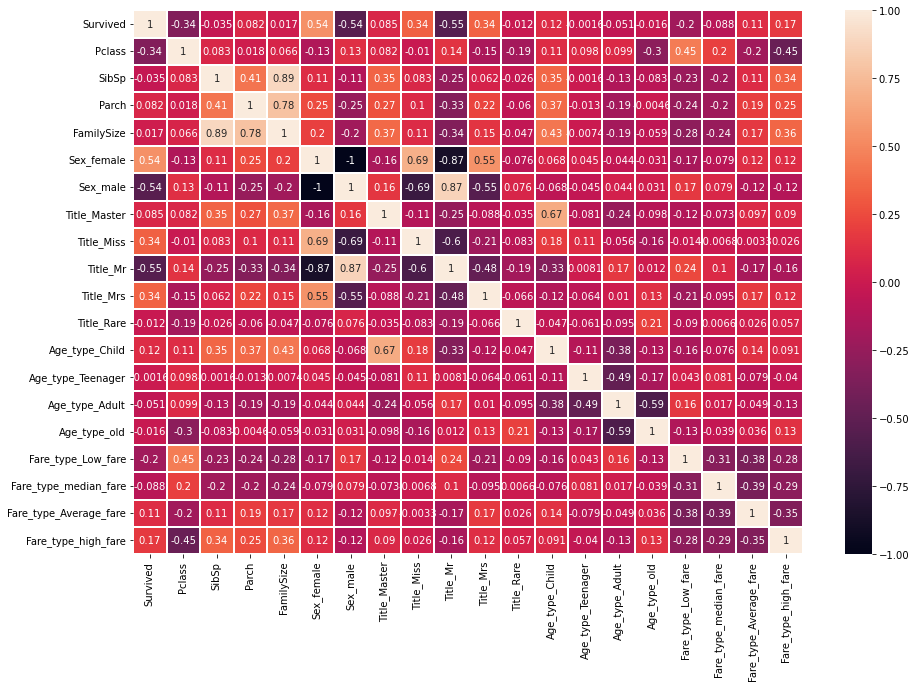

In [4]:
# Analyze feature correlations
sn.heatmap(train_dataset.corr(),annot=True,linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(15,10)
#plt.show()
plt.savefig("feature_correlation.png")

### Baselines

##### Based on majority class

In [5]:
print("Survived:", len(train_dataset.loc[train_dataset["Survived"] == 1]))
print("Died:", len(train_dataset.loc[train_dataset["Survived"] == 0]))
print("Assign majority class: Everybody died (assign label 0 to every person in test set)")
print("Yielded accuracy: 0.622")

Survived: 342
Died: 549
Assign majority class: Everybody died (assign label 0 to every person in test set)
Yielded accuracy: 0.622


In [6]:
# # Write majority class prediction
# test_dataset["Survived"] = 0
# test_dataset_baseline_majority = test_dataset[['PassengerId', 'Survived']]
# test_dataset_baseline_majority.to_csv("./predictions/test_csv_baseline_majority.csv", index=False)

##### Based on feature classes

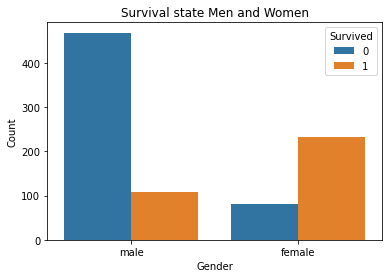

In [7]:
plt.figure(figsize=(6, 4))
sn.countplot(x=train["Sex"], hue=train["Survived"])
plt.title("Survival state Men and Women")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()
#plt.savefig("survival_men_woman.png")

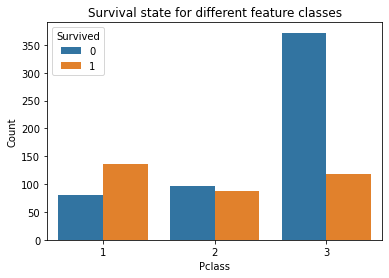

In [8]:
plt.figure(figsize=(6, 4))
sn.countplot(x=train_dataset["Pclass"], hue=train_dataset["Survived"])
plt.title("Survival state for different feature classes")
plt.xlabel("Pclass")
plt.ylabel("Count")
plt.show()
#plt.savefig("survival_classes.png")

We can construct different feature classes for the passengers given their Sex and Pclass parameter value. We predict their survival according to the class they belong to:

- Male & 3rd class: 0
- Male & 2nd class: 0
- Male & 1st class: 0
- Female & 3rd class: 0
- Female & 2nd class: 1
- Female & 1st class: 1

In [9]:
print("Assign feature classes: Females in 2nd and 1st class survived, rest died")
print("Yielded accuracy: 0.755")

Assign feature classes: Females in 2nd and 1st class survived, rest died
Yielded accuracy: 0.755


In [11]:
test_dataset

,PassengerId,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age_type_Child,Age_type_Teenager,Age_type_Adult,Age_type_old,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,892,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
1,893,3,1,0,2,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0
2,894,2,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0
3,895,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
4,896,3,1,1,3,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
414,1306,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
415,1307,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
416,1308,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0


In [14]:
# Write feature class prediction
td_cl = copy_dataframe(test)
td_cl["Survived"] = 0
td_cl.loc[(td_cl['Sex'] == "female") & (td_cl['Pclass'] == 2), 'Survived'] = 1
td_cl.loc[(td_cl['Sex'] == "female") & (td_cl['Pclass'] == 1), 'Survived'] = 1
td_cl = td_cl[['PassengerId', 'Survived']]
# td_cl.to_csv("./predictions/test_csv_feature_classes.csv", index=False)

##### Excursion: Principal Component Analysis

In [15]:
train_pca = train.copy()
train_pca.loc[train_pca["Sex"] == "female", "Sex"] = 1
train_pca.loc[train_pca["Sex"] == "male", "Sex"] = 0
train_pca = train_pca[["Pclass", "Sex", "Age", "Parch", "Fare"]]
train_pca = train_pca.dropna()
train_pca

,Pclass,Sex,Age,Parch,Fare
0,3,0,22.0,0,7.2500
1,1,1,38.0,0,71.2833
2,3,1,26.0,0,7.9250
3,1,1,35.0,0,53.1000
4,3,0,35.0,0,8.0500
...,...,...,...,...,...
885,3,1,39.0,5,29.1250
886,2,0,27.0,0,13.0000
887,1,1,19.0,0,30.0000
889,1,0,26.0,0,30.0000


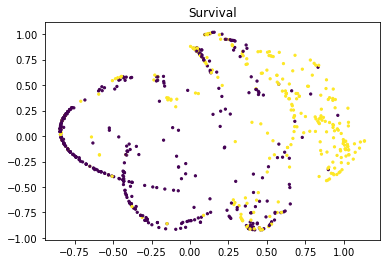

In [16]:
# PCA
pca = PCA(n_components=2)
preprocessed_train = preprocessing.normalize(preprocessing.scale(train_pca))
# missing feature scaling and normalization
pca.fit(preprocessed_train)
trans = pca.transform(preprocessed_train)
# Plotting
trdf = train_dataset[train['Age'].notna()]
plt.scatter(trans[:,0], trans[:,1], s=5, c=trdf['Survived'])
plt.title("Survival")
plt.show()
#plt.savefig("./pca.png")

## Logistic regression

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [18]:
# Provide training set
X = copy_dataframe(train_dataset)
# Remove unecessary columns for training
y = X['Survived'] #trying to predict
X.drop('Survived',axis=1,inplace=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train) # Train model
predictions = logmodel.predict(X_test) # Predict on held out test set for performance report

In [20]:
print("Performance on y_test:")
print(classification_report(y_test,predictions))

Performance on y_test:
              precision    recall  f1-score   support

           0       0.75      0.92      0.82        51
           1       0.85      0.59      0.70        39

    accuracy                           0.78        90
   macro avg       0.80      0.76      0.76        90
weighted avg       0.79      0.78      0.77        90



In [21]:
# Adjust test set
test_data_logistic = copy_dataframe(test_dataset)
ids_logistic = test_data_logistic["PassengerId"] # truth
test_data_logistic.drop(['PassengerId'],axis=1,inplace=True)

# Predict on test set
predictions_test_data = logmodel.predict(test_data_logistic)
predictions_logistic = pd.DataFrame({"PassengerId":ids_logistic, "Survived": predictions_test_data})

# Write predictions
#predictions_logistic.to_csv("./predictions/test_csv_logistic.csv", index=False)

## Classification methods

#### Neural Network

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.autograd import Variable

In [23]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(19, 270)
        self.fc2 = nn.Linear(270, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
net = MLP()

In [24]:
# Train -> Used for training the model
train_ds = copy_dataframe(train_dataset)
# Test -> Used for final predictions
test_ds = copy_dataframe(test_dataset)

X_train = train_ds.iloc[:, 1:20].values # Input features
X_train = X_train.astype(np.int32)
Y_train = train_ds.iloc[:, 0].values # Labels
Y_train = Y_train.astype(np.int32)
X_test = test_ds.iloc[:, 1:20].values
X_test = X_test.astype(np.int32)

# Train/Validation split for training
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2)

In [25]:
# Model training
batch_size = 8
num_epochs = 50
learning_rate = 0.01
batch_no = len(x_train) // batch_size

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    if epoch % 5 == 0:
        print('Epoch {}'.format(epoch+1))
    x_train, y_train = shuffle(x_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(x_train[start:end]))
        y_var = Variable(torch.LongTensor(y_train[start:end]))
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        ypred_var = net(x_var)
        loss = criterion(ypred_var, y_var)
        loss.backward()
        optimizer.step()

Epoch 1
Epoch 6


/Users/georg/miniconda3/envs/Ml4RG/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 11
Epoch 16
Epoch 21
Epoch 26
Epoch 31
Epoch 36
Epoch 41
Epoch 46


In [26]:
# Evaluate the model on held out validation set
test_var = Variable(torch.FloatTensor(x_val), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
values, labels = torch.max(result, 1)
num_right = np.sum(labels.data.numpy() == y_val)
print('Accuracy {:.2f}'.format(num_right / len(y_val)))

Accuracy 0.82


In [27]:
# Make predictions on test set
X_test_var = Variable(torch.FloatTensor(X_test), requires_grad=True)
X_test_var

tensor([[3., 0., 0.,  ..., 0., 0., 0.],
        [3., 1., 0.,  ..., 0., 0., 0.],
        [2., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [3., 0., 0.,  ..., 0., 0., 0.],
        [3., 0., 0.,  ..., 1., 0., 0.],
        [3., 1., 1.,  ..., 0., 1., 0.]], requires_grad=True)

In [28]:
# Applying model on the test data
with torch.no_grad():
    test_result = net(X_test_var)
values, labels = torch.max(test_result, 1)
survived = labels.data.numpy()

# Write predictions
mlp_output = pd.DataFrame({"PassengerId": test_dataset["PassengerId"], "Survived": survived})
#mlp_output.to_csv("./predictions/mlp_predictions.csv", index=False)

#### Random Forest Classifier

In [29]:
# Train -> Used for training the model
train_ds = copy_dataframe(train_dataset)
# Test -> Used for final predictions
test_ds = copy_dataframe(test_dataset)

train_ds.drop(['SibSp', 'Parch'],axis=1,inplace=True)
test_ds.drop(['SibSp', 'Parch'],axis=1,inplace=True)

X_train = train_ds.iloc[:, 1:18].values # Input features
X_train = X_train.astype(np.int32)
Y_train = train_ds.iloc[:, 0].values # Labels
Y_train = Y_train.astype(np.int32)

X_test = test_ds.iloc[:, 1:18].values
X_test = X_test.astype(np.int32)
# Train/Validation split for training
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2)

In [31]:
# # Hyperparameter search
# from sklearn.model_selection import GridSearchCV, cross_val_score
# param_grid = {"n_estimators": [3, 5, 6, 8, 10, 50, 100, 400, 700, 1000, 1500, 3000, 4000, 5000, 6000]}

# clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#                max_depth=10, max_features='sqrt', max_leaf_nodes=None,
#                min_impurity_decrease=0.0,
#                min_samples_leaf=5, min_samples_split=2,
#                min_weight_fraction_leaf=0.0, #n_estimators=6,
#                n_jobs=None, oob_score=False, random_state=None,
#                verbose=0, warm_start=False)
# clf = GridSearchCV(estimator=clf, param_grid=param_grid)
# clf.fit(X_train, Y_train)
# print(clf.best_params_)

In [32]:
# Random forest
random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
               max_depth=10, max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0,
               min_samples_leaf=5, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=400,
               n_jobs=None, oob_score=False, random_state=None,
               verbose=0, warm_start=False)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [33]:
print("score:", round(acc_random_forest,2,), "%")

score: 84.51 %


In [34]:
# Increased performance by about 1%
importances = pd.DataFrame({'feature':train_ds.iloc[:, 1:21].columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Pclass,0.171
Sex_female,0.162
Sex_male,0.158
Title_Mr,0.153
FamilySize,0.110
Title_Mrs,0.038
Title_Miss,0.035
Fare_type_high_fare,0.034
Fare_type_Low_fare,0.024


In [35]:
# Write predictions
random_forest_output = pd.DataFrame({"PassengerId": test_dataset["PassengerId"], "Survived": Y_prediction})
#random_forest_output.to_csv("./predictions/random_forest_predictions.csv", index=False)